# Matrix Factorization
Matrix Factorization is based on the simple idea that user and item interactions are measured by how their **embeddings** interact with each other. This interaction manifests itself in the multiplication of these embeddings, which, since we're talking about vector embeddings, leads to the **dot product** as simple mathematical operation as the main base of this approach.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Oct 03 04:06:36 2020

@author: Ufkun-Bayram Menderes

This Python Module contains the implementation of Recommender Systems for the 
goodbooks10k dataset based on Matrix Factorization.
Training for model is provided via train.py modul
The Model is implemented in PyTorch.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from load_goodbooks_ds import *
from encode_books import proc_col, encode_data
from train import train_epochs, test_loss
import pandas as pd
from metrics import *

###############################################################################
# 1st part: Loading the goodbooks dataset from the load_goodbooks_ds.py file
# In that file, the dataset is alredy split up into training, validation and test
# sets
##############################################################################


# number of users for embeddings = 53424
num_users = train_ratings.user_id.nunique()
# number of books = 10000
num_items = train_ratings.book_id.nunique()
# determine min and max ratings
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])
second_highest = max_rating - 1

min_user_id = min(ratings["user_id"])
max_user_id = max(ratings["user_id"])

print("Number of users: {}, Number of books: {}, Min rating: {}, Max rating: {}"
      .format(num_users_total, num_items, min_rating, max_rating))

###############################################################################
# In this part, we will create a Matrix Factorization model with PyTorch 
# with corresponding item and user embeddings.
###############################################################################


class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        """
        Matrix Factorization class which embeds both users and items 
        into nn.Embeddings according to chosen embedding size

        Parameters
        ----------
        num_users : int
            number of users of a given dataset
        num_items : int
            number of items of a given dataset
        emb_size : int, optional
            size of each emebedding. The default is 100.

        Returns
        -------
        MF object

        """
        super(MF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, emb_size)
        self.item_embedding = nn.Embedding(num_items, emb_size)
        self.user_embedding.weight.data.uniform_(0, 0.05)
        self.item_embedding.weight.data.uniform_(0, 0.05)
    
    def forward(self, user, item):
        """
        Performs computations of Matrix Factorization for users and books
        

        Parameters
        ----------
        user_vec : nn.Embedding
            Embedding layer of users and user_id's
        item_vec : nn.Embedding
            Embedding layer of items and item_id's

        Returns
        -------
        TYPE : torch.tensor 
        PyTorch tensor containing output of forward pass


        """
        user_vec = self.user_embedding(user)
        item_vec = self.item_embedding(item)
        return (user_vec*item_vec).sum(1)
    
    def recommend(self, user_id, n=150, r=3):
        """
        Recommends n top items to a user 

        Parameters
        ----------
        user_id : int
            integer representation of a user, will be converted to a torch.Tensor
        n : int, optional
            number of top recommendations which we will return.
            The default is 10.
        
        r : int, optional
            Decimal places to which predicted rating shall be rounded up to

        Returns
        -------
        recommendations : list
            list top n recommendations with predicted ratings

        """
        if user_id > max_user_id or user_id < min_user_id:
            raise ValueError("Invalid user ID")
        books = load_books()
        user = torch.tensor([user_id])
        books_recommend = torch.tensor(ratings.book_id.unique().tolist()) - 1
        predictions = model(user, books_recommend).tolist()
        # normalize the ratings according to given rating scale
        predictions = [i/max(predictions)*ratings.rating.max() for i in predictions]
        # zip the book_ids and corresponding rating prediction to a list of 
        # (rating, id) tuples
        book_ids = ratings.book_id.unique()
        predictions = list(zip(predictions, book_ids))
        # get the books which the user has alread read
        user_books_read = ratings[ratings.user_id == user]
        # make a list out of the book_id's that user has alread read
        read_list = list(user_books_read.book_id)
        # make an empty list for unread books, fill it with book_ids
        # of books that user has not rated/read yet
        unread_books = []
        for book in predictions:
            if book[1] not in read_list:
                unread_books.append(book)
        # sort the elements according to their rating, top ratings at top
        unread_books = sorted(unread_books, key=lambda book_tuple: book_tuple[0],
                              reverse=True)
        # indice the list on desired top n elements
        top_n_books = unread_books[:n]
        # get book_ids of top n elements
        top_n_book_ids = [books[1] for books in top_n_books]
        # get the full book information of these books from books.csv dataset
        recommended_books = books[books["id"].isin(top_n_book_ids)]
        # make dict out of top_n_books, keys=ratings, values=ids
        book_rating_dict = dict(top_n_books)
        # reverse keys and values s.t. ids are keys, ratings are values
        book_rating_dict = {value:key for key, value in book_rating_dict.items()}
        # make tuples out key, value elements, save them in the new list
        books_list_rev = [(k, v) for k, v in book_rating_dict.items()]
        # add a new dataframe with id, predicted rating tuples
        book_rating_tups = pd.DataFrame(books_list_rev, columns=['id','predicted_rating'])
        # merge both dataframes into one, id's column is common columns
        recommended_books = recommended_books.merge(book_rating_tups)
        # change predicted ratings >= 5.0 to 5
        recommended_books.loc[recommended_books['predicted_rating'] > 5.0, 'predicted_rating'] = 5.0
        # sort the predicted_rating column such that ratings with highest values
        # are at the top with descending order
        recommended_books = recommended_books.sort_values('predicted_rating', ascending=False)
        # round the values for predicted ratings
        recommended_books = recommended_books.round({'predicted_rating':r})
        # create new columns for predicted ratings on a 1-5 scale
        recommended_books['predicted_rating_scaled'] = recommended_books['predicted_rating']
        # round the ratings to zero decimal places so only values from 1-5 exist
        recommended_books = recommended_books.round({'predicted_rating_scaled':0})
        # return recommended books
        return recommended_books


#train_epochs(MF_model, epochs=35, lr=0.005)
model = MF(num_users, num_items, emb_size=100)
train_epochs(model, epochs=100, lr=0.01)


test_users = torch.LongTensor(test_ratings.user_id.values)
test_books = torch.LongTensor(test_ratings.book_id.values)
test_predictions = model(test_users, test_books)

# normalize the ratings
test_predictions = test_predictions.tolist()
test_predictions = [i/max(test_predictions)*max_rating for i in test_predictions]
# round the decimals to zero decimal places
test_predictions = list(np.around(test_predictions, 0))


Number of users: 53424, Number of books: 10000, Min rating: 1, Max rating: 5
Epoch:0, Loss:15.359225273132324
Epoch:1, Loss:14.908473014831543
Epoch:2, Loss:14.321557998657227
Epoch:3, Loss:13.606728553771973
Epoch:4, Loss:12.77322006225586
Epoch:5, Loss:11.832107543945312
Epoch:6, Loss:10.797161102294922
Epoch:7, Loss:9.685442924499512
Epoch:8, Loss:8.517854690551758
Epoch:9, Loss:7.319581985473633
Epoch:10, Loss:6.1204962730407715
Epoch:11, Loss:4.955141067504883
Epoch:12, Loss:3.862467050552368
Epoch:13, Loss:2.8847076892852783
Epoch:14, Loss:2.064992666244507
Epoch:15, Loss:1.442834734916687
Epoch:16, Loss:1.046865701675415
Epoch:17, Loss:0.8849510550498962
Epoch:18, Loss:0.9343993067741394
Epoch:19, Loss:1.1382067203521729
Epoch:20, Loss:1.4135740995407104
Epoch:21, Loss:1.6727217435836792
Epoch:22, Loss:1.846577763557434
Epoch:23, Loss:1.899783968925476
Epoch:24, Loss:1.8320664167404175
Epoch:25, Loss:1.6693273782730103
Epoch:26, Loss:1.4509927034378052
Epoch:27, Loss:1.218353509

In [2]:
model.recommend(3000)

,id,isbn,authors,year,title,avg_rating,predicted_rating,predicted_rating_scaled
77,5207,836217357,Bill Watterson,1993.0,The Days Are Just Packed: A Calvin and Hobbes ...,4.68,5.000,5.0
102,6920,751500283,Bill Watterson,1992.0,The Indispensable Calvin and Hobbes,4.73,4.908,5.0
149,9842,1250058902,Brandon Stanton,2015.0,Humans of New York: Stories,4.50,4.870,5.0
10,862,765326361,Brandon Sanderson,2014.0,"Words of Radiance (The Stormlight Archive, #2)",4.77,4.850,5.0
147,9566,1417642165,Bill Watterson,1992.0,Attack of the Deranged Mutant Killer Monster S...,4.72,4.847,5.0
...,...,...,...,...,...,...,...,...
129,8495,671876465,Lois McMaster Bujold,1994.0,"Mirror Dance (Vorkosigan Saga, #8)",4.32,4.446,4.0
0,110,553381695,George R.R. Martin,1998.0,"A Clash of Kings (A Song of Ice and Fire, #2)",4.40,4.446,4.0
145,9182,374180652,Michael J. Sandel,2009.0,Justice: What's the Right Thing to Do?,4.25,4.446,4.0
54,3341,NaN,Brandon Sanderson,2016.0,"The Bands of Mourning (Mistborn, #6)",4.45,4.446,4.0


## Extracting embeddings and embedding weights

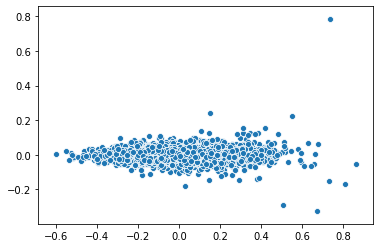

In [3]:
# Extract embeddings
book_embeddings = model.item_embedding
book_emb_weights = model.item_embedding.weight.detach().numpy()
#Visualizing Embedding weights
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

In [4]:
book_emb_weights = book_emb_weights / np.linalg.norm(book_emb_weights, axis = 1).reshape((-1, 1))
book_emb_weights[0][:10]
np.sum(np.square(book_emb_weights[0]))

1.0000002

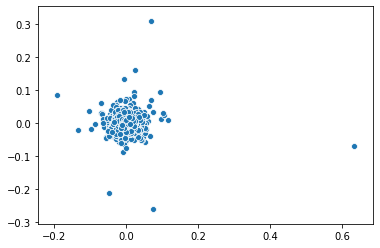

In [5]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

Interestingly, the Matrix Factorization embeddings are not as centered as one would expect and there are quite a few outliers. The bulk of embedding weights also centers around a certain spot very much, nonetheless, outliers are still clearly visible

## Evaluating the system
In order to properly perform the evalutaion, all 3 datasets were given the same input test set which was split from the validation test set and was completely unseen by all three models. However, I want to show the summary with sklearns's *classification_report* first, and then analyze the first metric - The regression loss

In [6]:
import sklearn
from sklearn.metrics import classification_report
true_ratings = test_ratings.rating
print(sklearn.metrics.classification_report(true_ratings, test_predictions, labels=[1, 2, 3, 4, 5], zero_division=0))

              precision    recall  f1-score   support

           1       0.02      0.02      0.02      1792
           2       0.06      0.66      0.12      6259
           3       0.25      0.32      0.28     24420
           4       0.35      0.00      0.01     36094
           5       0.00      0.00      0.00     29811

   micro avg       0.12      0.12      0.12     98376
   macro avg       0.14      0.20      0.08     98376
weighted avg       0.19      0.12      0.08     98376



In [7]:
regression_loss_bmf = regression_loss(test_predictions)
print("The regression loss for the MF model on the test data is: {}".format(regression_loss_bmf))

The regression loss for the MF model on the test data is: 1.6496401561356429


The regression loss of roughly 1.65 tells us that on average, our model's predicted ratings are off by 1.65 points on the scale, which, on a scale merely ranging from 1 to 5, is quite significant, especially since the recommendations will be ordered according to the predicted rating of each item. This shows that the model, despite performing well on the training and validation data, vastly underperforms on the test data due to what is most likely **overfitting**. The model could even struggle further with a rating scale that ranges from 1-10 or even higher.<br>
Next, we will look at how the differences among the predicted ratings are:

In [8]:
r1_count = test_predictions.count(1)
r2_count = test_predictions.count(2)
r3_count = test_predictions.count(3)
r4_count = test_predictions.count(4)
r5_count = test_predictions.count(5)

print("Total count of rating class 1 predicted: {}".format(r1_count))
print("Total count of rating class 2 predicted: {}".format(r2_count))
print("Total count of rating class 3 predicted: {}".format(r3_count))
print("Total count of rating class 4 predicted: {}".format(r4_count))
print("Total count of rating class 5 predicted: {}".format(r5_count))

Total count of rating class 1 predicted: 1490
Total count of rating class 2 predicted: 64740
Total count of rating class 3 predicted: 31875
Total count of rating class 4 predicted: 269
Total count of rating class 5 predicted: 1


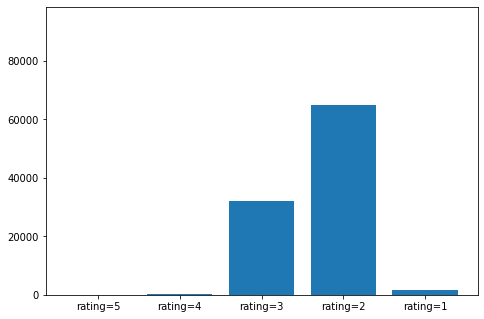

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [r5_count, r4_count, r3_count, r2_count, r1_count]
ax.bar(ratings,counts)
plt.show()

In [10]:
# First, we will analyze how many ratings are off by one
class_loss = classification_loss(test_predictions, diff=1)
print("Total amount of correctly predicted ratings: {}".format(len(test_ratings.rating) - class_loss[0]))
print("Total amount of incorrectly predicted ratings: {}".format(class_loss[0]))
print("Accuracy of the model in percent: {:.2f}%".format(class_loss[1]))
print("Predictions off by one: {}".format(class_loss[2]))
print("Percentage of ratings off by one out of all the test data: {:.2f}%".format(class_loss[3]*100))
print("Percentage of ratings off by one out of incorrectly predicted ratings: {:.2f}%".format(class_loss[4]*100))

Total amount of correctly predicted ratings: 12182
Total amount of incorrectly predicted ratings: 86194
Accuracy of the model in percent: 12.38%
Predictions off by one: 31175
Percentage of ratings off by one out of all the test data: 31.69%
Percentage of ratings off by one out of incorrectly predicted ratings: 36.17%


The accuracy of the model is merely about 12%, but what is even more striking is the fact that the ratings which were off by *just* one only are about 36%, which means that the model could only incorrectly predict only about a third of the test set with a slight margin of one. This indicates to greater differences for the other 64% among the incorrectly predicted data, which is even more troubling. 

In [11]:
# Now we analyze the ratings off by two
class_loss_two = classification_loss(test_predictions, diff=2)
print("Predictions off by two: {}".format(class_loss_two[2]))
print("Percentage of ratings off by two out of all the test data: {:.2f}%".format(class_loss_two[3]*100))
print("Percentage of ratings off by two out of incorrectly predicted ratings: {:.2f}%".format(class_loss_two[4]*100))

Predictions off by two: 34406
Percentage of ratings off by two out of all the test data: 34.97%
Percentage of ratings off by two out of incorrectly predicted ratings: 39.92%


The ratings that were off by two mark up pretty much 40% of the incorrectly predicted ratings. Granted, a difference of two might not seem like much, but given the context of a scale from 1-5 it is an important factor in how the recommendations are sorted.

In [12]:
#Ratings off by three
class_loss_three = classification_loss(test_predictions, diff=3)
print("Predictions off by three: {}".format(class_loss_three[2]))
print("Percentage of ratings off by three out of all the test data: {:.2f}%".format(class_loss_three[3]*100))
print("Percentage of ratings off by three out of incorrectly predicted ratings: {:.2f}%".format(class_loss_three[4]*100))

Predictions off by three: 20154
Percentage of ratings off by three out of all the test data: 20.49%
Percentage of ratings off by three out of incorrectly predicted ratings: 23.38%


Roughly a quarter of the incorrectly predicted ratings were off by three, which further emphasizes the model's failure to properly adjust to the testing data.

In [13]:
# Ratings off by four 
class_loss_four = classification_loss(test_predictions, diff=4)
print("Predictions off by four: {}".format(class_loss_four[2]))
print("Percentage of ratings off by four out of all the test data: {:.2f}%".format(class_loss_four[3]*100))
print("Percentage of ratings off by four out of incorrectly predicted ratings: {:.2f}%".format(class_loss_four[4]*100))

Predictions off by four: 459
Percentage of ratings off by four out of all the test data: 0.47%
Percentage of ratings off by four out of incorrectly predicted ratings: 0.53%


The predictions that were off by four mark are the least among the incorrectly predicted data, which shows that the model did manage to largest differences right, but still underperformed as the other values are quite high.


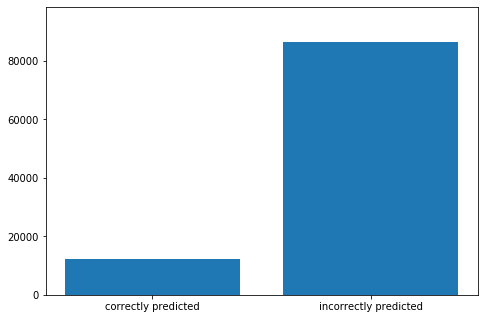

In [15]:
# Plotting the data to show difference between correctly and incorrectly predicted ratings
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ymax = len(test_ratings.rating)
ymin = 0
ax.set_ylim([ymin,ymax])
correct = ymax - class_loss[0]
offs = ['correctly predicted', 'incorrectly predicted']
counts = [correct, class_loss[0]]
ax.bar(offs,counts)
plt.show()

The bar plot further emphasizes the model's failre to properly fit the training data, although performing well on training and validation. This goes to show that the model has obvious problems with **generalization**

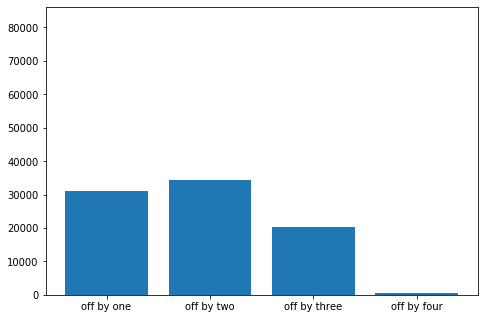

In [16]:
# Plotting the amount of ratings that were off by 1, 2, 3, 4 respectively out of all incorrectly predicted ratings
fig2 = plt.figure()
ax2 = fig2.add_axes([0,0,1,1])
ymax = class_loss[0]
ymin = 0
ax2.set_ylim([ymin,ymax])
offs = ['off by one', 'off by two', 'off by three', 'off by four']
counts = [class_loss[2],class_loss_two[2], class_loss_three[2], class_loss_four[2]]
ax2.bar(offs,counts)
plt.show()

In [18]:
# Recalls 
recall_five = recall_per(test_predictions, 5)
recall_four = recall_per(test_predictions, 4)
recall_three = recall_per(test_predictions, 3)
recall_two = recall_per(test_predictions, 2)
recall_one = recall_per(test_predictions, 1)
recall_total = recall_macro_avg(test_predictions)

print("Recall for rating 5: {:.3f}%".format(recall_five*100))
print("Recall for rating 4: {:.3f}%".format(recall_four*100))
print("Recall for rating 3: {:.3f}%".format(recall_three*100))
print("Recall for rating 2: {:.3f}%".format(recall_two*100))
print("Recall for rating 1: {:.3f}%".format(recall_one*100))
print("Total macro averaged recall: {:.3f}%".format(recall_total*100))

Recall for rating 5: 0.000%
Recall for rating 4: 0.260%
Recall for rating 3: 32.461%
Recall for rating 2: 65.969%
Recall for rating 1: 1.786%
Total macro averaged recall: 20.095%


The recall for all the rating classes shows that while total recall was relatively poor, the recall for rating class 2
is very high and thus the model managed to get the ratings for rating class 2 rather succesfully, while it clearly underperformed for rating class 5 since its recall value is 0, same can be said about rating class 4 and 1 which have also extremely low recall ratings. Rating class 3 also provides good recall, given the context of the other values. This indicates towards the fact that the model performed better on the lower values of the scale.

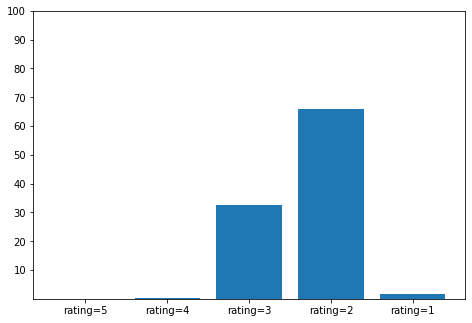

In [20]:
# Plotting the recall
fig3 = plt.figure()
ax3 = fig3.add_axes([0,0,1,1])
ticks = [10,20,30,40,50,60, 70, 80, 90, 100]
ax3.set_yticks(ticks)
ymax = 100
ymin = 0
ax3.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [recall_five*100, recall_four*100, recall_three*100, recall_two*100, recall_one*100]
ax3.bar(ratings,counts)
plt.show()

In [21]:
##Analyzing precisions
precision_five = precision_per(test_predictions, 5)
precision_four = precision_per(test_predictions, 4)
precision_three = precision_per(test_predictions, 3)
precision_two = precision_per(test_predictions, 2)
precision_one = precision_per(test_predictions, 1)
precision_total = precision_macro_avg(test_predictions)

print("Precision for rating 5: {:.3f}%".format(precision_five*100))
print("Precision for rating 4: {:.3f}%".format(precision_four*100))
print("Precision for rating 3: {:.3f}%".format(precision_three*100))
print("Precision for rating 2: {:.3f}%".format(precision_two*100))
print("Precision for rating 1: {:.3f}%".format(precision_one*100))
print("Total macro averaged precision: {:.3f}%".format(precision_total*100))

Precision for rating 5: 0.000%
Precision for rating 4: 34.944%
Precision for rating 3: 24.869%
Precision for rating 2: 6.378%
Precision for rating 1: 2.148%
Total macro averaged precision: 13.668%


Again, the model seems to have greatly struggled with the ratings of rating class 5 as the value is here once again a zero. It did however provide some results for rating classes 3 and 4 which are somewhat considerable, while rating class 2 has a precision of only about 6% and rating class 1 has a precision of about 2%.

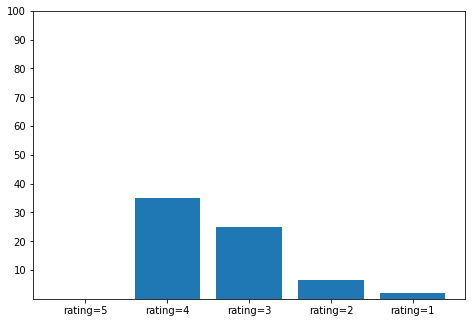

In [22]:
##Plotting precisions
# Plotting the recall
fig4 = plt.figure()
ax4 = fig4.add_axes([0,0,1,1])
ax4.set_yticks(ticks)
ymax = 100
ymin = 0
ax4.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [precision_five*100, precision_four*100, precision_three*100, precision_two*100, precision_one*100]
ax4.bar(ratings,counts)
plt.show()

Next, I will analyze the measures for F1-Score:

In [24]:
from sklearn.metrics import f1_score

# f1-scores taken from sk_learn since my original function in the metrics.py file had a bug
f_five =  0.00
f_four = 0.01
f_three = 0.28
f_two = 0.12
f_one = 0.02 
f_total = f1_score(test_ratings.rating, test_predictions, average='macro')
f1_total_weighted = f1_score(test_ratings.rating, test_predictions, average='weighted')
f1_total_micro = f1_score(test_ratings.rating, test_predictions, average='micro')


print("F1-measure for rating class 5: {:.3f}%".format(f_five*100))
print("F1-measure for rating class 4: {:.3f}%".format(f_four*100))
print("F1-measure for rating class 3: {:.3f}%".format(f_three*100))
print("F1-measure for rating class 2: {:.3f}%".format(f_two*100))
print("F1-measure total for the test set macro-averaged: {:.3f}%".format(f_total*100))
print("Weighted F1-measure for the test set {:.3f}%".format(f1_total_weighted*100))
print("Weighted F1-measure for the test set micro-averaged: {:.3f}%".format(f1_total_micro*100))

F1-measure for rating class 5: 0.000%
F1-measure for rating class 4: 1.000%
F1-measure for rating class 3: 28.000%
F1-measure for rating class 2: 12.000%
F1-measure total for the test set macro-averaged: 7.043%
Weighted F1-measure for the test set 7.956%
Weighted F1-measure for the test set micro-averaged: 12.383%


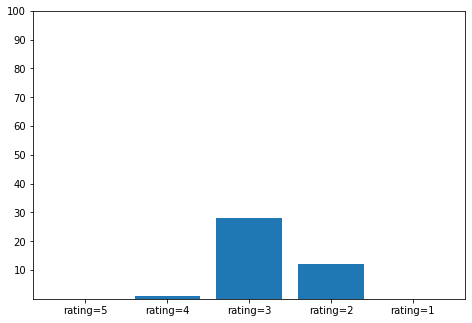

In [25]:
# Plotting the f-measures

fig5 = plt.figure()
ax5 = fig5.add_axes([0,0,1,1])
ax5.set_yticks(ticks)
ymax = 100
ymin = 0
ax5.set_ylim([ymin,ymax])
ratings = ['rating=5', 'rating=4', 'rating=3', 'rating=2', 'rating=1']
counts = [f_five*100, f_four*100, f_three*100, f_two*100, 0]
ax5.bar(ratings,counts)
plt.show()

Again, the awfully low ratings for rating class 1 and rating class 5 are instantly visible, which is no suprise due tot their low recall and precision, respectively. Rating class 3 however has a somewhat acceptable value for the F1-Score, followed by rating class 2.

## Conclusion
The evaluation on the test data clearly shows that the Matrix Factorization model struggles greatly with properly adjusting the model to unseen data; i.e. the model vastly **overfits**. Since the predicted ratings influence the recommendation process, this can become a problem with other databases that impose a different rating scale where fine differences could influence the recommendations greatly. On another note, Matrix Factorization requires normalization of the test prediction outputs which also takes some amount of time. All in all, Matrix Factorization provided a good result for training and validation, but couldn't live up to that result in the testing phase. In order to potentially improve the Matrix Factorization and save it from the problem of overfitting, we will next look at **Biased Matrix Factorization**